In [1]:
import onnxruntime 
import cv2
from matplotlib import pyplot as plt
from util import preprocess_segmentation, postprocess_segmentation, default_image_loader, preprocess_hash
import torch
import onnx
import numpy as np

image_path = "assets/dogs.jpg"

clip_input_size = 224
fastsam_input_size = 1024

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !pip install --upgrade onnx onnxruntime protobuf

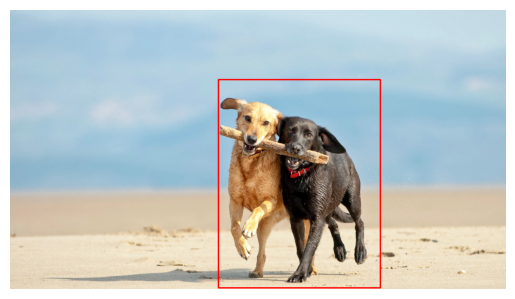

In [3]:
image = cv2.imread(image_path)
box = [450, 150, 800, 600] # Query box

x1, y1, x2, y2 = box
cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

# 1. Segmentation

Start an ONNX Session with the FastSAM segmentation model

In [4]:
fastsam_onnx = "/data/models/FastSAM-x.onnx"
session_seg = onnxruntime.InferenceSession(fastsam_onnx, providers=[
    # 'CUDAExecutionProvider'
    'CPUExecutionProvider'
]) 

### Inputs

In [5]:
for x in session_seg.get_inputs():
    print(x.name)

images


### Outputs

In [6]:
for x in session_seg.get_outputs():
    print(x.name)

output0
output1


### Run FastSAM model

In [7]:
img = cv2.imread(image_path)
processed_image = preprocess_segmentation(img)

preds =  session_seg.run(["output0", "output1"], { "images": processed_image } )
preds = [torch.from_numpy(preds[0]) , torch.from_numpy(preds[1])]

In [8]:
retina_masks = True
conf = 0.25
iou = 0.7
agnostic_nms = False

segmentation_result = postprocess_segmentation(preds, processed_image, img, retina_masks, conf, iou)

# 2. Hashing

Start an ONNX Session with the Hashing model

In [9]:
image = default_image_loader(image_path) 
hash_model = "/data/models/sa.onnx" 
session_hash = onnxruntime.InferenceSession(hash_model
                                            , providers=['CPUExecutionProvider'] # CPU
                                            #, providers=['CUDAExecutionProvider'] # GPU
                                            ,
                                            verbose=True)

In [10]:
# model = onnx.load(hash_model)

In [11]:
mask_crops, fastsam_crops, clip_crops  = preprocess_hash(segmentation_result, image_path, box, torch.device("cuda:0"),
                                                        clip_input_size=clip_input_size, 
                                                         fastsam_input_size=fastsam_input_size)

In [12]:
mask = mask_crops[0][0]

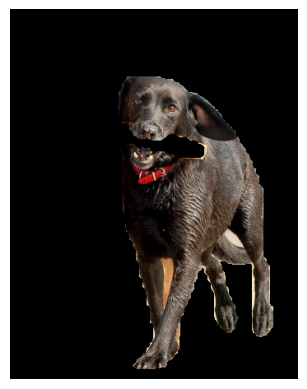

In [13]:
x1, y1, x2, y2 = box
image = cv2.imread(image_path)[y1:y2,x1:x2,:]
resized_mask = cv2.resize(mask, (image.shape[1], image.shape[0]))
resized_mask = (resized_mask * 255).astype(np.uint8)
result_image = cv2.bitwise_and(image, image, mask=resized_mask)
result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
plt.imshow(result_image_rgb)
plt.axis('off')
plt.show()

In [14]:
mask_crops.shape, fastsam_crops.shape, clip_crops.shape

((1, 1, 1024, 800), (1, 3, 1024, 800), (1, 3, 224, 224))

In [15]:
mask_crops.dtype, fastsam_crops.dtype, clip_crops.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

In [16]:
code = session_hash.run(["output"], { "mask_crops": mask_crops,
                            "clip_crops": clip_crops,
                             "fastsam_crops": fastsam_crops } )
"".join(map(str,code[0]))

'1100101101111100111110000001100011010110100011110111110100101101001001001010101101111110101110011100011100010100001010010100111110100101101001001010111011001111110101011010011001010010101100001010011110011111100110011011110001101100101101011000010110010011'

In [ ]:
import time
for i in range(10):
    start = time.time()   
    
    preds =  session_seg.run(["output0", "output1"], { "images": processed_image } )
    preds = [torch.from_numpy(preds[0]) , torch.from_numpy(preds[1])]
    
    segmentation_result = postprocess_segmentation(preds, processed_image, img, retina_masks, conf, iou)
    
    end_segment = time.time() - start
    

    
    mask_crops, fastsam_crops, clip_crops  = preprocess_hash(segmentation_result, image_path, box, torch.device("cuda:0"),
                                                        clip_input_size=clip_input_size, 
                                                         fastsam_input_size=fastsam_input_size)
    
    code =  session_hash.run(["output"], { "mask_crops": mask_crops,
                                "clip_crops": clip_crops,
                                 "fastsam_crops": fastsam_crops } )

    end = time.time() - start
    # print("".join(map(str,code[0])))
    print("%s processed in %f seconds (segment: %f, hash: %f)" % (image_path, end, end_segment, end-end_segment))

assets/dogs.jpg processed in 7.841751 seconds (segment: 3.897123, hash: 3.944628)
assets/dogs.jpg processed in 5.945066 seconds (segment: 3.350498, hash: 2.594568)
assets/dogs.jpg processed in 5.749507 seconds (segment: 3.305077, hash: 2.444430)
assets/dogs.jpg processed in 5.797964 seconds (segment: 3.104106, hash: 2.693858)
assets/dogs.jpg processed in 6.151911 seconds (segment: 3.470006, hash: 2.681906)
assets/dogs.jpg processed in 6.163688 seconds (segment: 3.427401, hash: 2.736288)
